In [1]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py
sys.path.append('/home/analysis_user/New_trap_code/SensitivityFramework/')
from signal_model_utilities_v3 import *
from shutil import copyfile

plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [2]:
def repeat(arr, count):
    z_sig = []
    for i in range(count):
        z_sig.extend(arr)
    return z_sig


def mock_injection_signal_from_bkg(alpha_scale,lambda_val,height_sep=-15.5,x_sep=13.9,offset_y=+4.9,phase_shift="TF"):
    stroke=-202
    frequency=3
    axis="z"
    yuk_or_grav="yuk"
    alpha=1
    bead_size=7.6
    signal_sim = force_vs_time(x_sep,height_sep,stroke,frequency,axis,lambda_val,offset_y,yuk_or_grav,alpha,bead_size)
    
    # shift phase of signal according to TF
        # data from Nadav's google doc [https://docs.google.com/spreadsheets/d/132wBYgWQt44M5gDtw48kFwvLDv416yS83ISfGujQUt4/edit#gid=0]

    # convert to bits, this works only for one second chunk!
        # data from Nadav's google doc [https://docs.google.com/spreadsheets/d/132wBYgWQt44M5gDtw48kFwvLDv416yS83ISfGujQUt4/edit#gid=0]

    TF_phases = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07]    
    if(phase_shift=="TF"):TF_phase_shift = TF_phases
    elif(phase_shift=="Flip"):TF_phase_shift = [-1*element for element in TF_phases] # this flips
    elif(phase_shift=="Random_TF"):TF_phase_shift = [1*np.random.normal(element,element/20) for element in TF_phases]
    elif(phase_shift=="Random"):TF_phase_shift =  np.random.uniform(-np.pi,np.pi,len(TF_phases))
    else:TF_phase_shift = len(TF_phases)*[0]
    print(TF_phase_shift)
    harmonics = np.arange(3,len(TF_phases)*3+3,3)

    #print(len(TF_phase_shift))
    # 6 charges new
    amplitude_scale = [2.40E-17,1.35E-17,1.05E-17,9.78E-18,9.45E-18,9.81E-18,9.82E-18,1.04E-17,9.92E-18,7.50E-18,8.37E-18,7.10E-18,7.84E-18]

    fft_sim = np.fft.rfft(signal_sim[1]) 
    new_fft_sim = fft_sim.copy()
    new_fft_shift_only = fft_sim.copy()
    #new_fft_sim[0]=1/np.mean(amplitude_scale) * np.abs(fft_sim[0]) # not necessary?
    for harmonic in harmonics:
        new_fft_shift_only[harmonic] = np.abs(fft_sim[harmonic])*np.exp(1j*(np.angle(fft_sim[harmonic])+TF_phase_shift[harmonic//3-1]))
        new_fft_sim[harmonic] = 1/amplitude_scale[harmonic//3-1] * np.abs(fft_sim[harmonic])*np.exp(1j*(np.angle(fft_sim[harmonic])+TF_phase_shift[harmonic//3-1]))

    signal_sim_shift=np.fft.irfft(new_fft_shift_only) 
    signal_sim_shift_scale =np.fft.irfft(new_fft_sim) 
    
    
    # extend to 10s
    z_sig = repeat(signal_sim_shift_scale,10)
    # scale to desired alpha
    z_sig_10 = np.multiply(z_sig,alpha_scale)
    
    return z_sig_10,TF_phase_shift,amplitude_scale


def mock_injection_bkg(alpha_scale_bkg,lambda_val,height_sep=-15.5,x_sep=13.9,offset_y=+4.9,TF_phases_bkg = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07]):
    stroke=-202
    frequency=3
    axis="z"
    yuk_or_grav="yuk"
    alpha=1
    bead_size=7.6
    background_sim = force_vs_time(x_sep,height_sep,stroke,frequency,axis,lambda_val,offset_y,yuk_or_grav,alpha,bead_size)
    
    # shift phase of signal according to TF
        # data from Nadav's google doc [https://docs.google.com/spreadsheets/d/132wBYgWQt44M5gDtw48kFwvLDv416yS83ISfGujQUt4/edit#gid=0]

    # convert to bits, this works only for one second chunk!
        # data from Nadav's google doc [https://docs.google.com/spreadsheets/d/132wBYgWQt44M5gDtw48kFwvLDv416yS83ISfGujQUt4/edit#gid=0]
    harmonics = np.arange(3,len(TF_phases_bkg)*3+3,3)

    #print(len(TF_phase_shift))
    # 6 charges new
    
    #alpha_scale_bkg = [1/1]*len(TF_phases)#/1e10
    TF_amp_scale = [2.40E-17,1.35E-17,1.05E-17,9.78E-18,9.45E-18,9.81E-18,9.82E-18,1.04E-17,9.92E-18,7.50E-18,8.37E-18,7.10E-18,7.84E-18]
    amplitude_scale = np.multiply(TF_amp_scale,alpha_scale_bkg)
    fft_sim_bkg = np.fft.rfft(background_sim[1]) 
        
    new_fft_sim_bkg = fft_sim_bkg.copy()
    #new_fft_sim_bkg[0]=1/np.mean(amplitude_scale) * np.abs(fft_sim_bkg[0]) # not necessary?
    #print(np.abs(fft_sim_bkg[0]),1/np.mean(amplitude_scale),np.abs(new_fft_sim_bkg[0]))

    for harmonic in harmonics:
        new_fft_sim_bkg[harmonic] = 1/amplitude_scale[harmonic//3-1]*(np.abs(fft_sim_bkg[harmonic])) *np.exp(1j*(np.angle(fft_sim_bkg[harmonic])+TF_phases_bkg[harmonic//3-1]))

    signal_sim_bkg =np.fft.irfft(new_fft_sim_bkg) 
    
    
    # extend to 10s
    z_bkg = repeat(signal_sim_bkg,10)
    # scale to desired alpha - not used anymore
    z_bkg_10 = np.multiply(z_bkg,1)
    
    return z_bkg_10,TF_phases_bkg,amplitude_scale,alpha_scale_bkg

In [18]:
def file_creator_rounding_uniform_random_noise(final_signal,in_file_paths,out_dir,direction,run_no,max_file=1000):
    i=0
    out_dirs=  out_dir+"/%d/" %run_no
    try: os.makedirs(out_dirs)
    except: print("Did not create %s. It may exist or you do not have perimissions." %out_dir)    

    for file_path in tqdm(in_file_paths):
        #print(file_path)
        i+=1
        if(i<(max_file+1)):
            #if (i % 10==0):print("%f percent" %(i/max_file*100))
            with h5py.File(file_path, 'r') as f_in:
                quad_data_in = np.array(f_in['quad_data'])
                data_in = quad_data_in.reshape(-1,12).T[9]
                #plt.plot(np.array(data_in))
                random_uni =np.random.uniform(-0.5,0.5,len(data_in)) # make a list of random numbers between -0.5 and 0.5
                new_data_uni = data_in + random_uni# add them                 
                if(direction=="push"): z_sn = np.subtract(np.array(new_data_uni),np.array(final_signal))
                elif(direction=="pull"): z_sn = np.add(np.array(new_data_uni),np.array(final_signal))
                else: print("Force has to go either way")
                z_sn_round = [round(element) for element in z_sn] # round to half even
                quad_data_in.reshape(-1,12).T[9] = z_sn_round
                f_in.close()
                #plt.plot(np.array(z_sn),color="black")
            out_path = out_dirs + "Noise_batch_%d.h5" %(i-1)
            copyfile(src=file_path, dst=out_path)
            with h5py.File(out_path, 'r+') as f_out:
                del f_out['quad_data']
                f_out.create_dataset("quad_data", quad_data_in.shape,data=quad_data_in)
                f_out.close()
    return print("Done")

In [242]:
in_dir = r"/data/new_trap_processed/mockfiles/20200320/raw/noise/"
out_dir = r"/data/new_trap_processed/mockfiles/20200320/output/noise/bkg_simple/1/"

in_file_paths = []
for file_path in glob.iglob(in_dir+"*.h5"):
    in_file_paths.append(file_path)
    in_file_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))    


In [222]:
# make lists
alpha_scale_in = 4.5e8
lambda_val_in = 10
direction_in = "pull"
phase_shift_in = "TF"
alpha_scale_bkg_push = 5*[1/1e1]+[1/1e9]+7*[1/1e1]
alpha_scale_bkg_pull = 3*[1/1e1]+[1/2e8]+9*[1/1e1]
TF_phases_bkg_push = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07]
TF_phases_bkg_pull = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07]


In [223]:
z_sig_10,_,_ = mock_injection_signal_from_bkg(alpha_scale_in,lambda_val=lambda_val_in,height_sep=-15.5,x_sep=13.9,offset_y=+4.9,phase_shift="TF")


Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]


In [224]:
z_bkg_push,_,_,_= mock_injection_bkg(alpha_scale_bkg_push,lambda_val=lambda_val_in,height_sep=-15.5,x_sep=13.9,offset_y=+4.9,TF_phases_bkg=TF_phases_bkg_push)
z_bkg_pull,_,_,_= mock_injection_bkg(alpha_scale_bkg_pull,lambda_val=lambda_val_in,height_sep=-15.5,x_sep=13.9,offset_y=+4.9,TF_phases_bkg=TF_phases_bkg_pull)


Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force


In [225]:
final_signal = z_sig_10 - z_bkg_push + z_bkg_pull 

In [226]:
sig_fft = np.abs(np.fft.rfft(z_sig_10))
push_fft = np.abs(np.fft.rfft(z_bkg_push))
pull_fft = np.abs(np.fft.rfft(z_bkg_pull))


(0.0, 400.0)

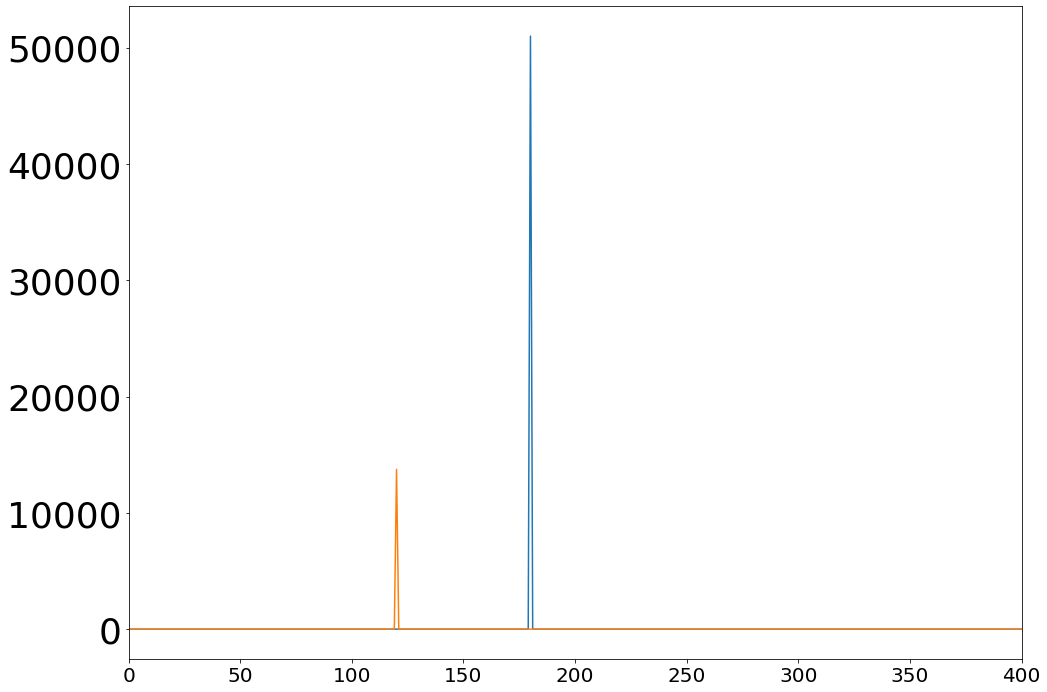

In [227]:
plt.plot(push_fft)
plt.plot(pull_fft)
plt.xlim(0,400)

(0.0, 5000.0)

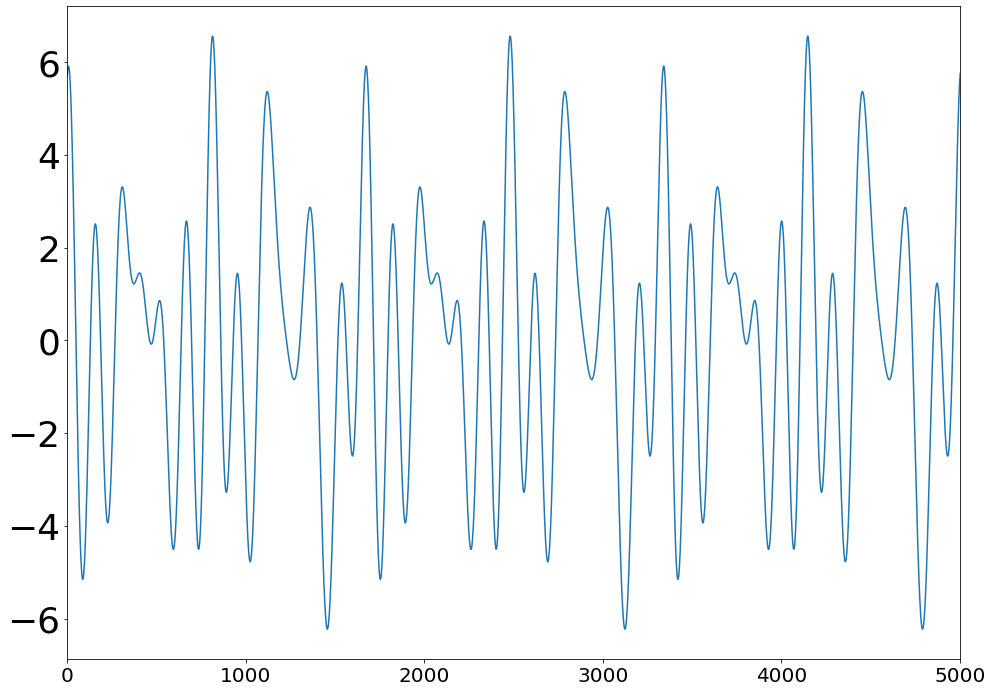

In [228]:
plt.plot(final_signal)
plt.xlim(0,5000)

In [229]:
file_creator_rounding_uniform_random_noise(final_signal,in_file_paths,out_dir,direction=direction_in,run_no=0,max_file=1000)    


  0%|          | 1/1000 [00:00<01:57,  8.51it/s]

Did not create /data/new_trap_processed/mockfiles/20200320/output/noise/bkg_simple/2/. It may exist or you do not have perimissions.


100%|██████████| 1000/1000 [01:42<00:00,  9.74it/s]

Done


In [243]:
file_avg = 1001

  0%|          | 2/1000 [00:00<00:57, 17.31it/s]

1000


100%|██████████| 1000/1000 [00:32<00:00, 30.44it/s]


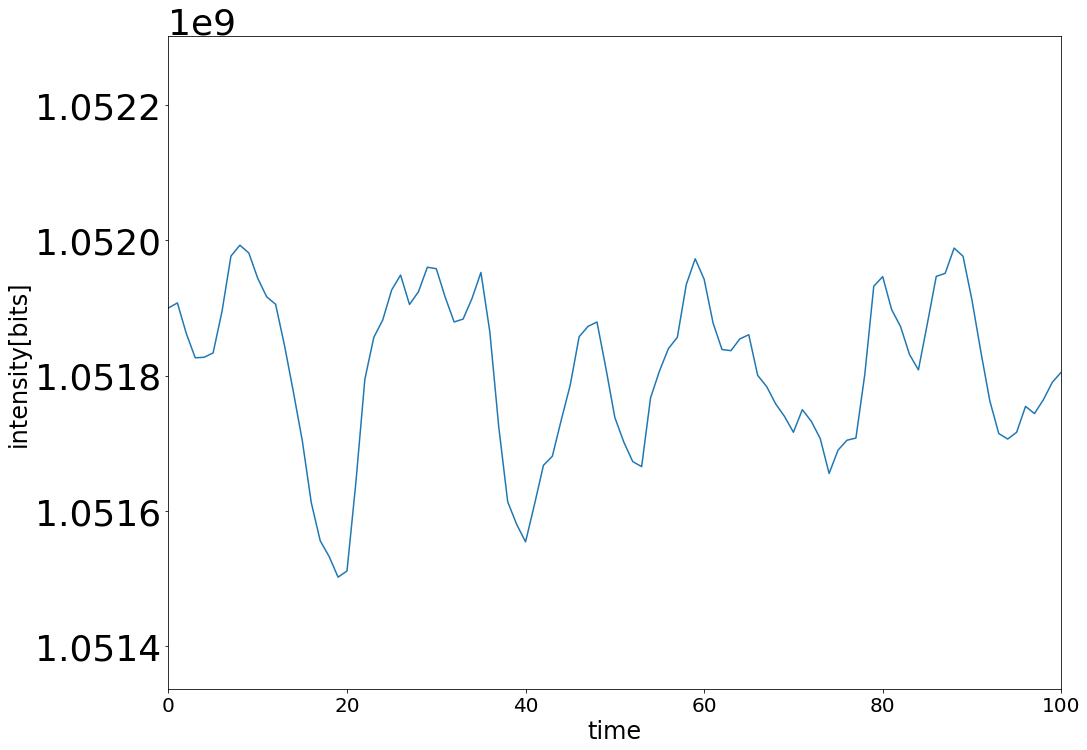

In [244]:
# step 1: load a raw file
in_file_paths = []
for file_path in glob.iglob(in_dir+"*.h5"):
    in_file_paths.append(file_path)

#in_file_paths=[in_dir+"NoShaking_1_200.h5",in_dir+"NoShaking_1_602.h5",in_dir+"NoShaking_1_173.h5"]

data_raw_sum=0    
print(len(in_file_paths))
i=0
for raw_file in tqdm(in_file_paths):
    #print(raw_file)
    i+=1
    if(i<file_avg):
        with h5py.File(raw_file, 'r') as f_raw:
            quad_data_raw = np.array(f_raw['quad_data'])
            data_raw = quad_data_raw.reshape(-1,12).T[9]
            f_raw.close()
        data_raw_sum=data_raw_sum+data_raw
plt.plot(data_raw_sum)
plt.xlim(0,100)
plt.xlabel("time")
plt.ylabel("intensity[bits]")
plt.show()

  0%|          | 2/1000 [00:00<01:08, 14.60it/s]

1000


100%|██████████| 1000/1000 [00:11<00:00, 88.85it/s]


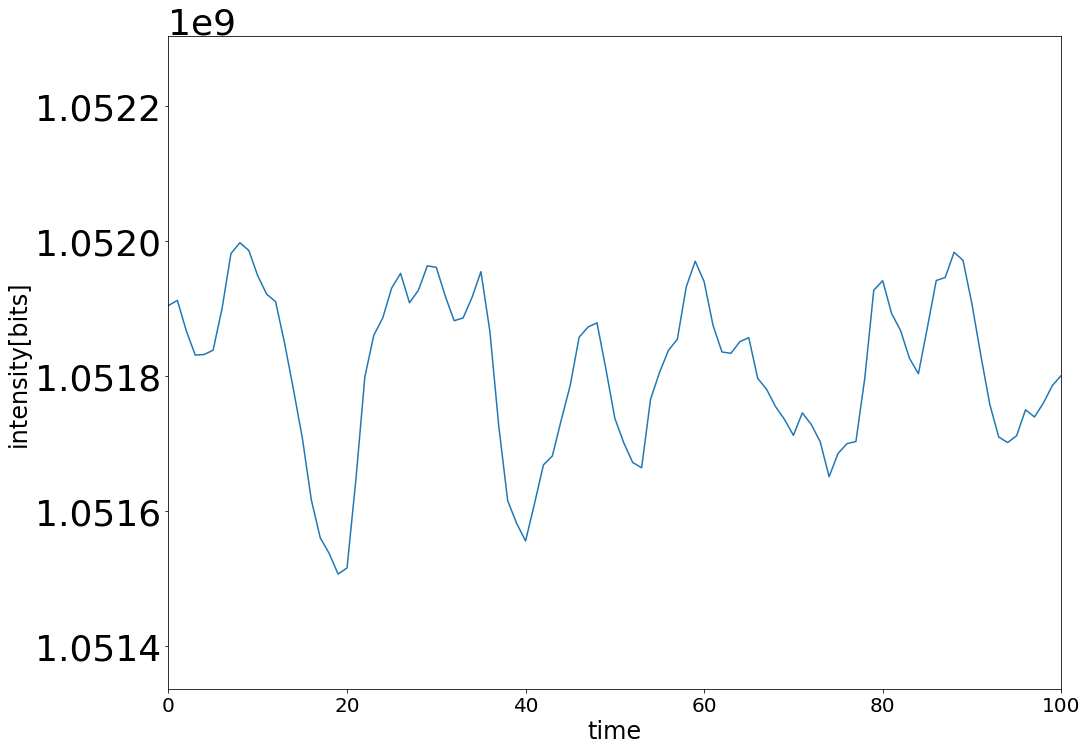

In [245]:
out_file_paths = []
for file_path in glob.iglob(out_dir+"/0/"+"*.h5"):
    out_file_paths.append(file_path)
    out_file_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))    

print(len(out_file_paths))

#out_file_paths = [out_dir+"/0/Noise_batch_0.h5",out_dir+"/0/Noise_batch_3.h5",out_dir+"/0/Noise_batch_1.h5"]

data_sum=0
i=0
for test_file in tqdm(out_file_paths):
    #print(test_file)
    i+=1
    if(i<file_avg):
        with h5py.File(test_file, 'r') as f_in:
            quad_data_in = np.array(f_in['quad_data'])
            data_in = quad_data_in.reshape(-1,12).T[9]
            f_in.close()    
        data_sum=data_sum+data_in

plt.plot(data_sum)
plt.xlim(0,100)
plt.xlabel("time")
plt.ylabel("intensity[bits]")
plt.show()

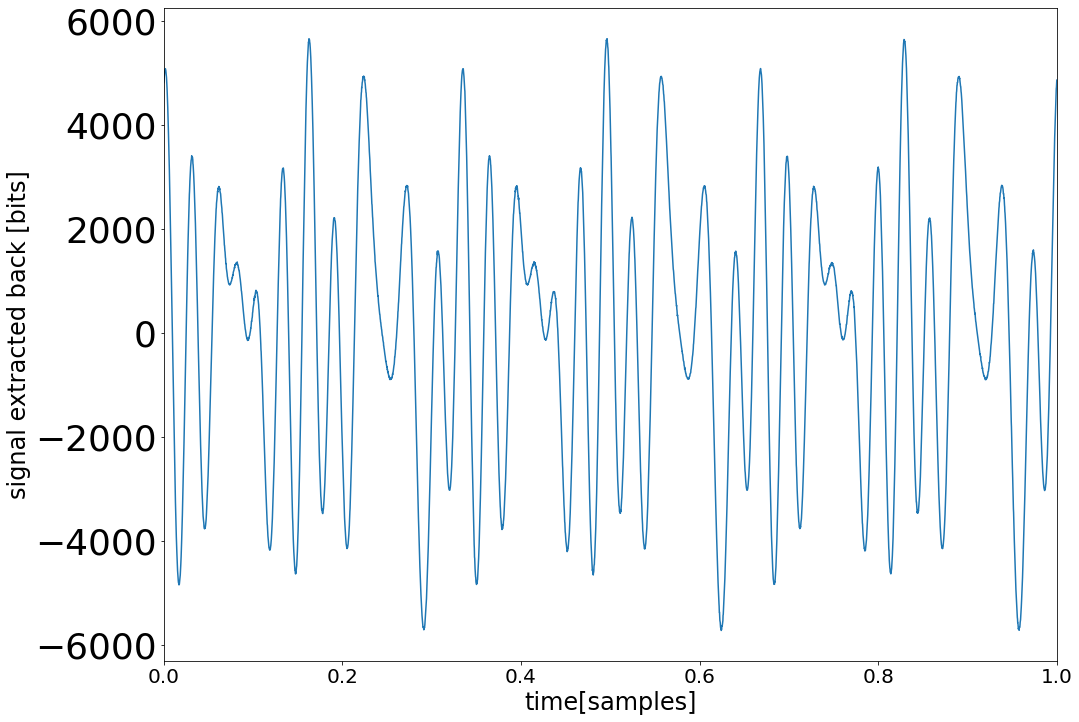

In [246]:
x=np.arange(0,10,1/5000)
plt.plot(x,data_sum-data_raw_sum)
plt.xlim(0,1)
plt.ylabel("signal extracted back [bits]")
plt.xlabel("time[samples]")
plt.show()

In [247]:
diff = data_sum-data_raw_sum
final_comp = final_signal*(file_avg-1)

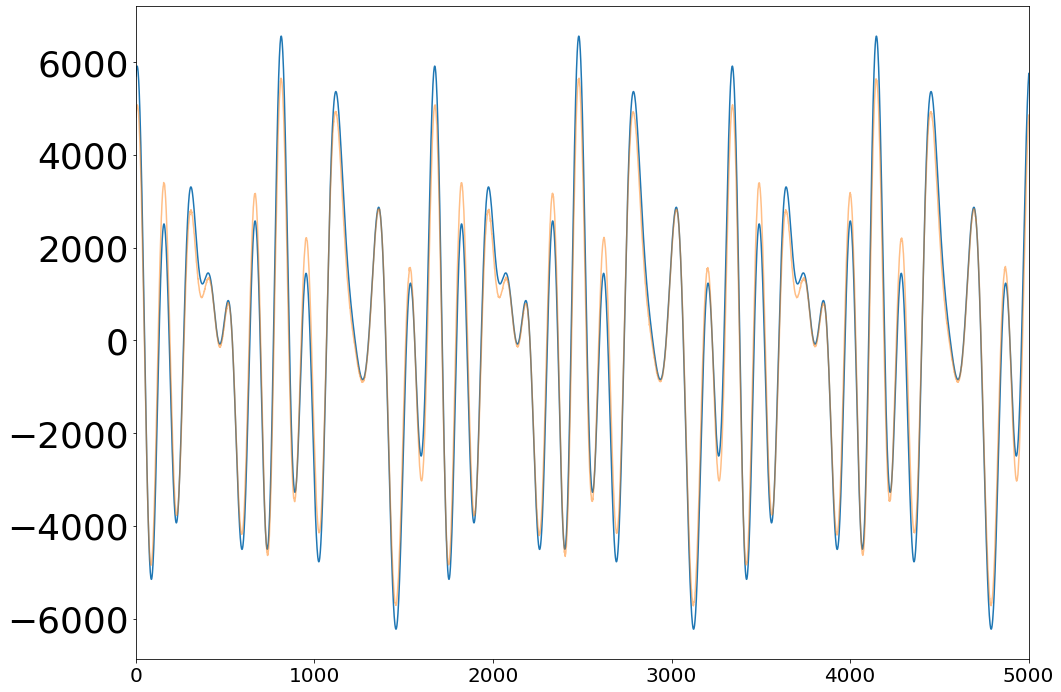

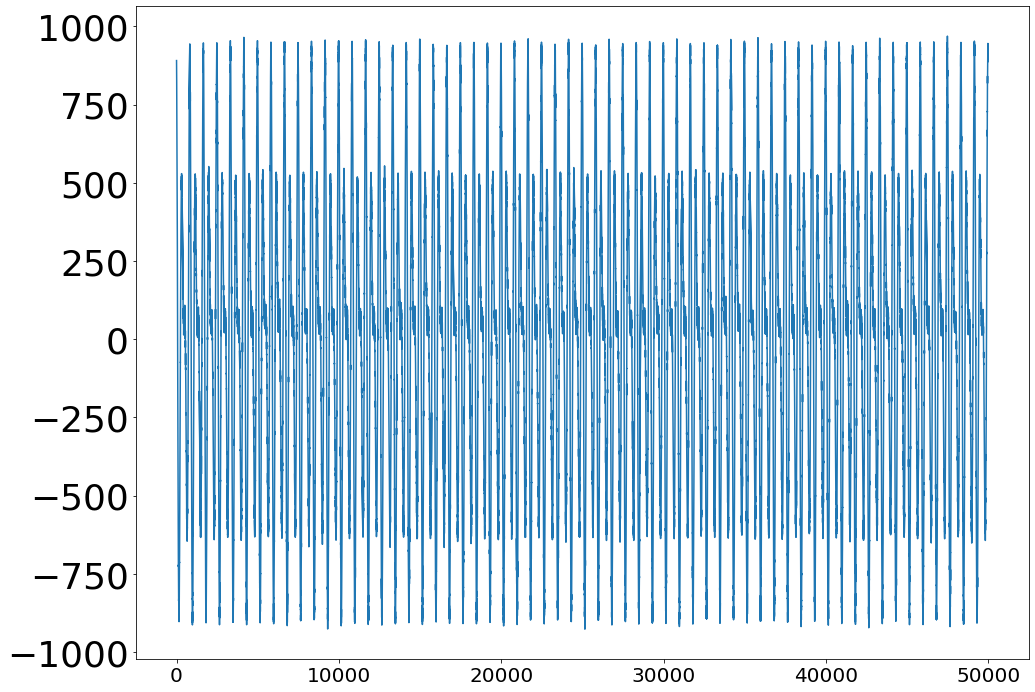

In [248]:
plt.plot(final_comp)
plt.plot(diff,alpha=0.5)
plt.xlim(0,5000)
plt.show()
plt.plot((final_comp-diff))
plt.show()

In [249]:
diff_fft=np.abs(np.fft.rfft(diff))
diff_angle =np.angle(np.fft.rfft(diff))
theo_fft = np.abs(np.fft.rfft(final_comp))
theo_angle = np.angle(np.fft.rfft(final_comp))
z_comp=z_sig_10*(file_avg-1)
sig_fft = np.abs(np.fft.rfft(z_comp))
sig_angle=np.angle(np.fft.rfft(z_comp))

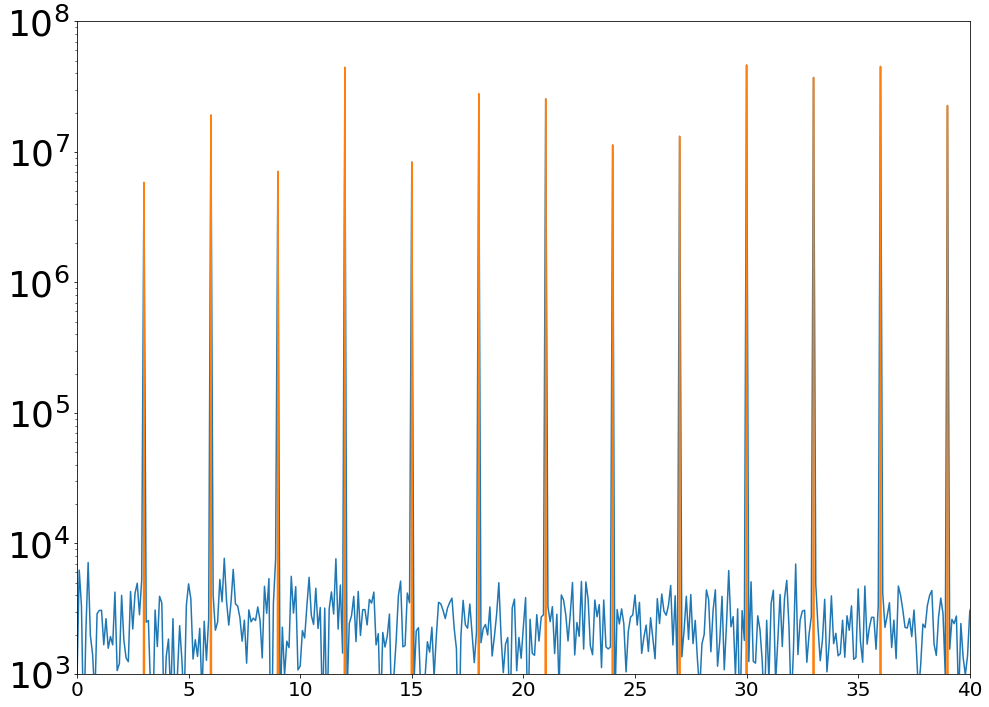

In [250]:
x=np.arange(0,2500.1,0.1)
plt.plot(x,diff_fft)
plt.plot(x,theo_fft)
plt.yscale("log")
plt.xlim(0,40)
plt.ylim(10e2,10e7)
plt.show()

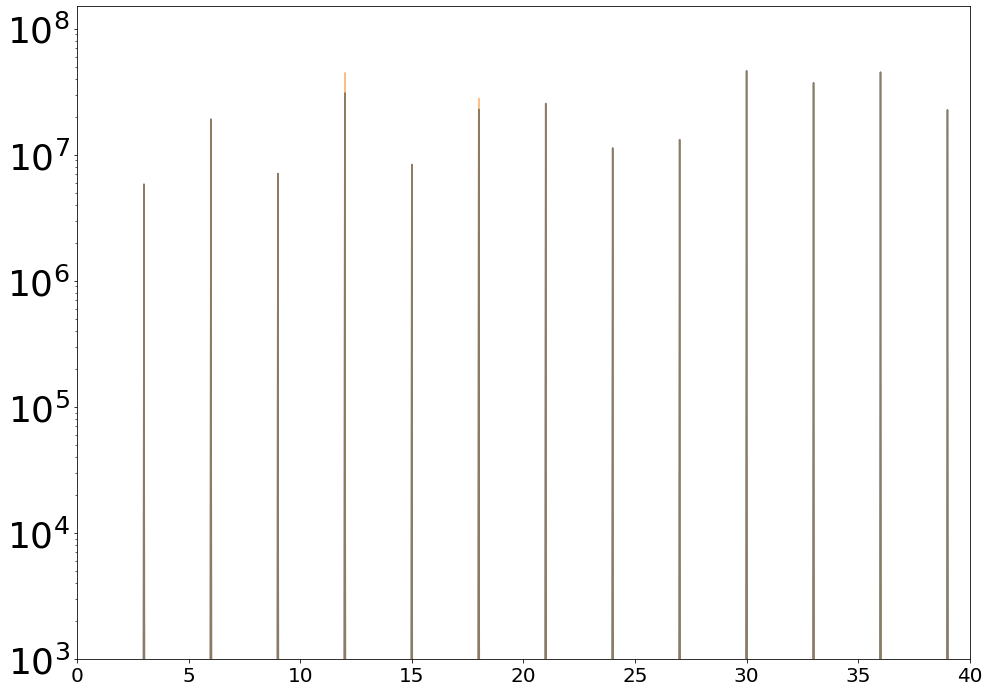

In [251]:
plt.plot(x,sig_fft)
plt.plot(x,theo_fft,alpha=0.5)
plt.yscale("log")
plt.xlim(0,40)
plt.ylim(10e2,15e7)
plt.show()

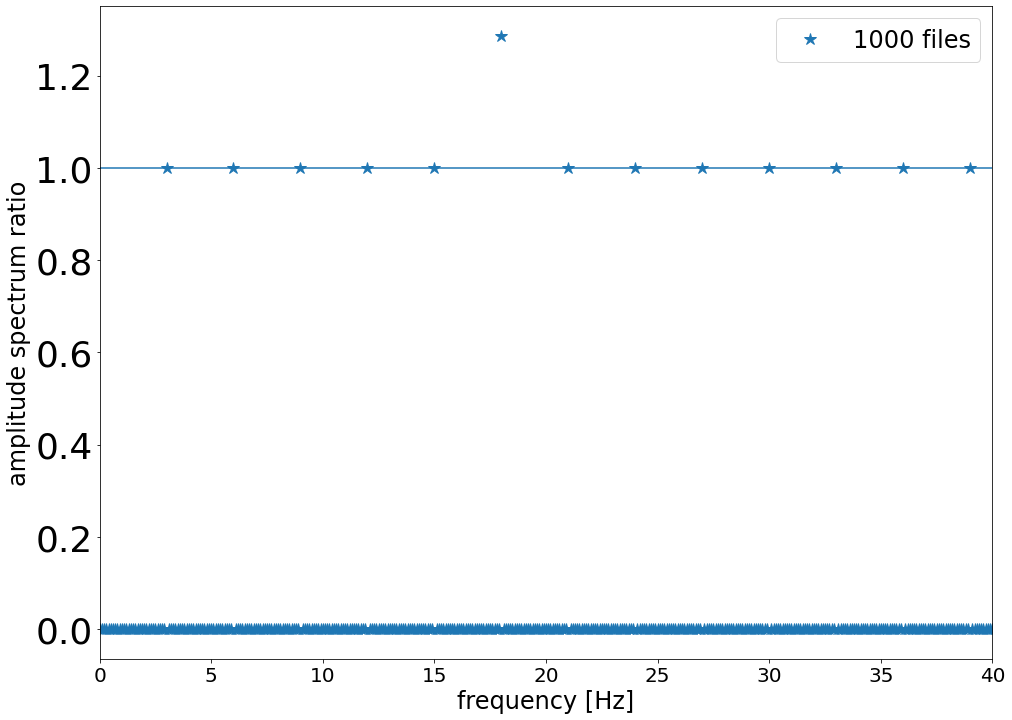

In [252]:
#ratio50=theo_fft/diff_fft
#ratio1=theo_fft/diff_fft
#plt.plot(x,theo_fft/diff_fft,linestyle="",marker="*",markersize=12,label="1000 files")
plt.plot(x,sig_fft/diff_fft,linestyle="",marker="*",markersize=12,label="1000 files")
#plt.plot(x,ratio50,linestyle="",marker="*",markersize=12,label="50 files")
#plt.plot(x,ratio1,linestyle="",marker="*",markersize=12,label="1 file")
plt.xlim(0,40)
#plt.ylim(0.90,1.1)
plt.ylabel("amplitude spectrum ratio")
plt.xlabel("frequency [Hz]")
plt.axhline(1)
plt.legend()
plt.show()

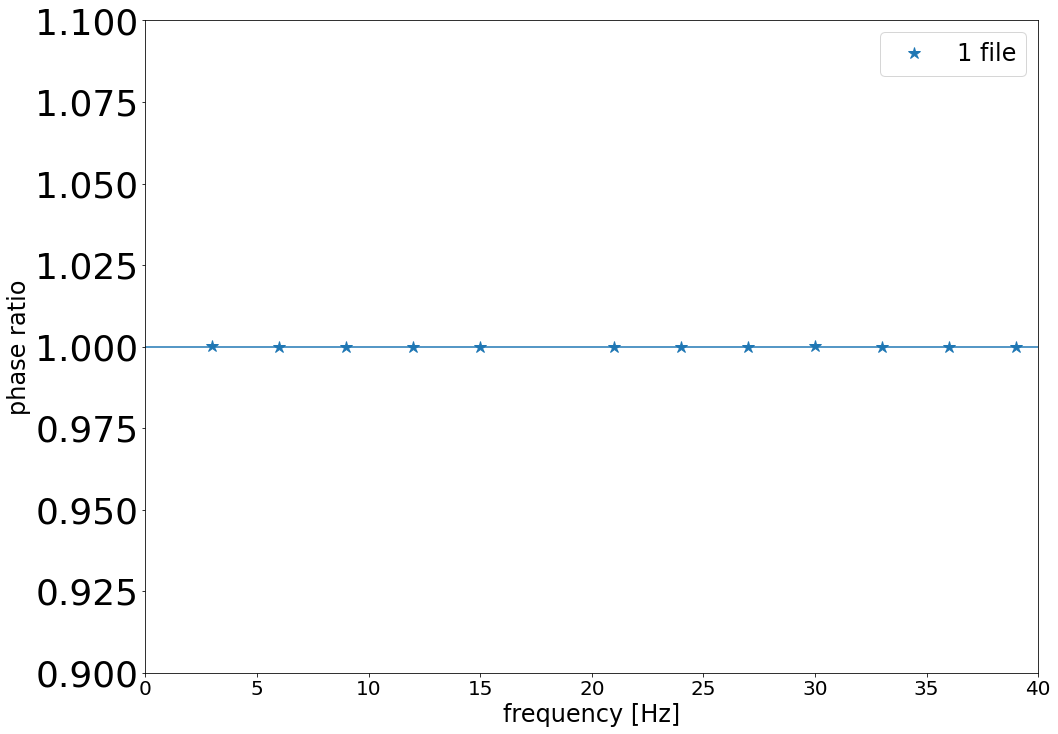

In [253]:
harms=np.arange(3,42,3)
ratio_1=[theo_angle[xa]/diff_angle[xa] for xa in np.arange(30,420,30)]
ratio_2 = [sig_angle[xa]/diff_angle[xa] for xa in np.arange(30,420,30)]
#ratio50=[theo_angle[xa]/diff_angle[xa] for xa in np.arange(30,420,30)]
#ratio1=[theo_angle[xa]/diff_angle[xa] for xa in np.arange(30,420,30)]
#ratio1000=[theo_angle[xa]/diff_angle[xa] for xa in np.arange(30,420,30)]
#plt.plot(harms,ratio1000,linestyle="",marker="*",markersize=12,label="1000 files")
#plt.plot(harms,ratio50,linestyle="",marker="*",markersize=12,label="50 files")
#plt.plot(harms,ratio_1,linestyle="",marker="*",markersize=12,label="1 file")
plt.plot(harms,ratio_2,linestyle="",marker="*",markersize=12,label="1 file")
plt.xlim(0,40)
plt.ylim(0.90,1.1)
#plt.axvline(3)
plt.ylabel("phase ratio")
plt.xlabel("frequency [Hz]")
plt.axhline(1)
#plt.axhline(1)
plt.legend()
plt.show()

In [308]:
theo_angle

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])